# Ariane 5 Vulcain Engine

This notebook attempts to use Bamboo to recreate experimental and simulation data produced for the Ariane 5's Vulcain engine.

Key points on the Vulcain engine:
- The combustion chamber is cooled seperately to the nozzle extension
- The nozzle extension is cooled by dump cooling
- The combustion chamber is regeneratively cooled

We will only attempt to model the regeneratively cooled combustion chamber.

### Conclusions:
- Bamboo seems to overpredict heat transfer rates (when using the 'bartz-sigma' gas-side model and 'gnielinski' coolant-side model).
- We can use a fudge factor to multiply the gas-side thermal resistance by, to obtain results that better match the experimental data. In this case a factor of 1.3 seemed reasonable.
- Heat transfer rates in the converging section of the nozzle remain overpredicted even with the fudge factor. One possible source of this error is Bamboo assuming the gas enters fully combusted (at its combustion temperature), whereas in reality it combustion would take place over a finite distance into the chamber.
- The mass flow rate required for Bamboo for nozzle choking was significantly different to the actual value used by the engine (176 kg/s in Bamboo vs 234 kg/s in real life). One possible cause for this is Bamboo's assumption that the exhaust is a perfect gas.

### References:

- [1] - http://servidor.demec.ufpr.br/CFD/bibliografia/propulsao/kirner_et_al_1993.pdf
- [2] - https://www.researchgate.net/publication/224789875_Thermomechanical_Analysis_and_Optimization_of_Cryogenic_Liquid_Rocket_Engines 
- [3] - https://www.macro-inc.com/NASADocs/AdvanceRocketEnginesEN-AVT-150-06.pdf
- [4] - https://www.sto.nato.int/publications/STO%20Educational%20Notes/RTO-EN-AVT-150/EN-AVT-150-05.pdf (note this link downloads a PDF)


### Uses of references:
- [1] - Predicted and experimental coolant temperatures and heat transfer rates for the Vulcain engine, from page 10.
- [2] - Thermal conductivity of the walls (310 W/m/K), from page 844.
- [3] - Cooling channel dimensions were estimated using the image on page 21.
- [4] - Turbopump exit pressure, assumed to be the coolant inlet pressure, from the graph on page 3 (noting that Vulcain is a gas-generator cycle with 1450 psi chamber pressure, giving ~2400 psi pump exit pressure (165 bar))



In [1]:
import bamboo as bam
import pypropep as ppp
from CoolProp.CoolProp import PropsSI
import matplotlib.pyplot as plt
import numpy as np

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 130

Using a an online graph image-to-data converter, we can obtain the raw data from MBB (Messerschmitt-Bölkow-Blohm).

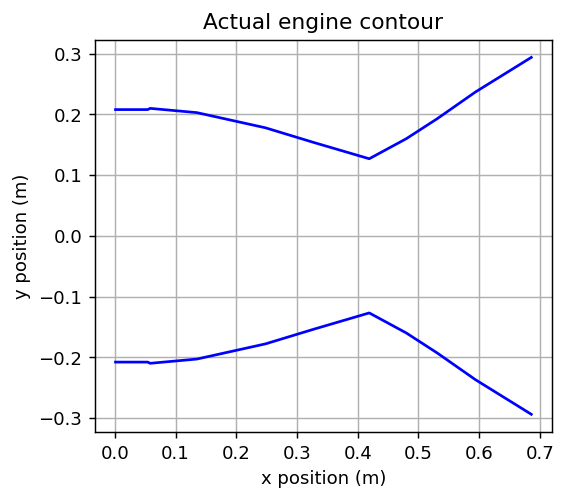

In [2]:
#'x' key corresponds to position in metres (0 = beginning of chamber). 'y' corresponds to the data.

#Coolant temperature in K 
coolant_temperature_data = {"x":[-0.002,0.012,0.029,0.045,0.197,0.26,0.32,0.37,0.424,0.485,0.529,0.592,0.648,0.687],
                            "y":[92.203,90.169,88.136,86.441,68.983,61.186,53.39,45.763,38.814,30.339,24.407,17.119,11.186,6.78]}

#Heat transfer rate in W/cm^2
heat_transfer_rate = {"x":[-0.003,0.022,0.036,0.049,0.062,0.086,0.113,0.129,0.152,0.171,0.192,0.205,0.221,0.244,0.27,0.294,0.31,0.327,0.342,0.36,0.368,0.382,0.398,0.421,0.439,0.447,0.452,0.465,0.477,0.49,0.5,0.512,0.524,0.534,0.548,0.564,0.58,0.596,0.612,0.631,0.647,0.664,0.688],
                      "y":[3374.422,3577.812,3697.997,3744.222,3762.712,3716.487,3661.017,3661.017,3670.262,3688.752,3707.242,3771.957,3818.182,3938.367,4114.022,4335.901,4539.291,4816.641,5075.501,5334.361,5574.73,5796.61,5935.285,5861.325,5648.69,5214.176,4983.051,4594.761,4298.921,3827.427,3522.342,3161.787,2930.663,2662.558,2440.678,2191.063,1996.918,1821.263,1710.324,1590.139,1479.199,1386.749,1322.034]}

#Engine contour (m) - up to the beginning of the nozzle extension.
engine_contour = {"x":[0.001,0.054,0.058,0.135,0.248,0.327,0.419,0.48,0.531,0.594,0.686],
                  "y":[0.208,0.208,0.21,0.203,0.178,0.154,0.127,0.16,0.193,0.237,0.294]}

#Plot the engine contour
fig, axs = plt.subplots()
axs.plot(engine_contour["x"], engine_contour["y"], color = 'blue')
axs.plot(engine_contour["x"], -np.array(engine_contour["y"]), color = 'blue')
axs.set_aspect('equal')
axs.grid()
plt.title("Actual engine contour")
axs.set_xlabel("x position (m)")
axs.set_ylabel("y position (m)")
plt.show()

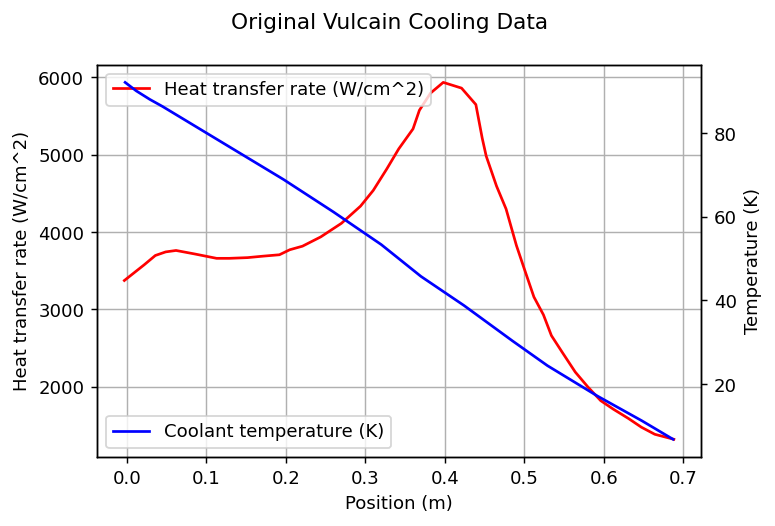

In [3]:
#Plot the original data from MBB
fig, ax1 = plt.subplots()
fig.suptitle("Original Vulcain Cooling Data")

#Plot heat transfer rates
ax1.plot(heat_transfer_rate["x"], heat_transfer_rate["y"], label="Heat transfer rate (W/cm^2)", color="red")

ax1.set_xlabel("Position (m)")
ax1.set_ylabel("Heat transfer rate (W/cm^2)")
ax1.grid()
ax1.legend(loc = "upper left")

#Plot coolant temperatures on the same axis
ax2 = ax1.twinx()       #Second axes that shares the same x-axis as ax1
ax2.plot(coolant_temperature_data["x"], coolant_temperature_data["y"], label="Coolant temperature (K)", color="blue")
ax2.set_ylabel("Temperature (K)")
ax2.legend(loc = 'lower left')

plt.show()

### Bamboo engine model

The Vulcain uses a liquid oxygen and liquid hydrogen fed system.

In [4]:
thrust = 1007.7e3   #N - in vacuum
isp = 439           #seconds - in vacuum
pc = 100e5
OF_ratio = 5.6      #by mass I believe

#Actual mass flow rate was incompatible with throat area (for perfect gas choking)
#Bamboo suggested using this value (which noticeably lower than the actual value of 234 kg/s)
mdot = 176.03 #thrust/(isp*9.81) 

#Use pypropep to get chamber temperature
ppp.init()
e = ppp.Equilibrium()
lox = ppp.PROPELLANTS['OXYGEN (LIQUID)']
lh2 = ppp.PROPELLANTS['HYDROGEN (CRYOGENIC)']

#Add propellants by mass fractions
e.add_propellants_by_mass([(lox, OF_ratio), (lh2, 1)])

#Adiabatic combustion using chamber pressure                      
e.set_state(P = pc/1e5, type='HP')     

#Get results
gamma = e.properties.Isex   #pyrpopep uses 'Isex' for the ratio of specific heats
cp = 1000*e.properties.Cp   #Cp is given in kJ/kg/K, we want J/kg/K
Tc = e.properties.T

print(f"\nTotal mass flow rate = {mdot} kg/s")
print(f"Chamber temperature = {Tc} K")

print("\nCombustion product composition:")
print(e.composition)

Loaded 1921 thermo species
Loaded 1031 propellants

Total mass flow rate = 176.03 kg/s
Chamber temperature = 3459.2606127242298 K

Combustion product composition:
{'H': 0.028801796474919292, 'HO2': 1.7031381331243065e-05, 'H2': 0.2896925690851782, 'H2O': 0.6493671319106238, 'H2O2': 7.94208687267654e-06, 'O': 0.0016810512414820072, 'OH': 0.028980423622929952, 'O2': 0.0014520541971763574, 'O3': 0.0}


In [5]:
#Need to convert contour data into something we can use for Bamboo - shift the data so the throat occurs at x = 0.
throat_pos = 0.419
nozzle_x = (np.array(engine_contour["x"]) - throat_pos)[6:]
nozzle_y = np.array(engine_contour["y"])[6:]

chamber_x = (np.array(engine_contour["x"]) - throat_pos)[:7]
chamber_y = np.array(engine_contour["y"])[:7]

#Set up the engine object
perfect_gas = bam.PerfectGas(gamma = gamma, cp = cp)   
chamber_conditions = bam.ChamberConditions(pc, Tc, mdot)
nozzle = bam.Nozzle(type = "custom", xs = nozzle_x, ys = nozzle_y)

engine = bam.Engine(perfect_gas, chamber_conditions, nozzle)

In [6]:
#Engine geometry
engine.add_geometry(inner_wall_thickness = 1.7e-3,
                    style = "custom",
                    xs = chamber_x,
                    ys = chamber_y)


In [7]:
'''Transport properties'''
#Setup the exhaust gas transport properties - assume the exhaust gas is purely water for simplicity
def Pr_gas(T, p):
    return PropsSI("PRANDTL", "T", T, "P", p, "WATER")

def mu_gas(T, p):
    return PropsSI("VISCOSITY", "T", T, "P", p, "WATER")

def k_gas(T, p):
    return PropsSI("CONDUCTIVITY", "T", T, "P", p, "WATER")

gas_transport = bam.cooling.TransportProperties(type = "functions",
                                                Pr = Pr_gas,
                                                mu = mu_gas,
                                                k = k_gas)

#Set up the coolant transport properties
#Round temperatures up to 12 K - CoolProp seems unhappy below this for LH2
def Pr_coolant(T, p):
    if T < 12:
        T = 12
    return PropsSI("PRANDTL", "T", T, "P", p, "HYDROGEN")

def mu_coolant(T, p):
    if T < 12:
        T = 12
    return PropsSI("VISCOSITY", "T", T, "P", p, "HYDROGEN")

def k_coolant(T, p):
    if T < 12:
        T = 12
    return PropsSI("CONDUCTIVITY", "T", T, "P", p, "HYDROGEN")

def cp_coolant(T, p):
    if T < 12:
        T = 12
    return PropsSI("CPMASS", "T", T, "P", p, "HYDROGEN") 

def rho_coolant(T, p):
    if T < 12:
        T = 12
    return PropsSI("DMASS", "T", T, "P", p, "HYDROGEN") 

'''
def T_from_enthalpy(enthalpy, p):
    return PropsSI('T','H', enthalpy,'P', p, 'HYDROGEN')

def enthalpy_from_T(T, p):
    return PropsSI('H','T', T, 'P', p, 'HYDROGEN')
'''

#H2 doesn't seem to exactly 'boil-off' in the state it's in, so just use cp for coolant temperature rise, not enthalpies.
coolant_transport = bam.cooling.TransportProperties(type = "functions",
                                                    Pr = Pr_coolant,
                                                    mu = mu_coolant,
                                                    k = k_coolant,
                                                    cp = cp_coolant,
                                                    rho = rho_coolant)

#Add the gas transport properties to the engine
engine.add_exhaust_transport(gas_transport)

#Coolant transport properties will get used later when creating adding the CoolingJacket to the engine

In [8]:
#Wall material
vulcain_wall_material = bam.cooling.Material(E = float("NaN"), 
                                    sigma_y = float("NaN"), 
                                    poisson = float("NaN"), 
                                    alpha = float("NaN"), 
                                    k = 310, 
                                    c = float("NaN"))

In [9]:
#Dimensions estimated from the image in Reference [3]
engine.add_cooling_jacket(inner_wall_material = vulcain_wall_material, 
                          inlet_T = 6.78,                           
                          inlet_p0 = 165e5, 
                          coolant_transport = coolant_transport, 
                          mdot_coolant = mdot/OF_ratio, 
                          configuration = "vertical", 
                          channel_height = 9.1e-3,
                          blockage_ratio = 0.5,
                          number_of_ribs = 288)

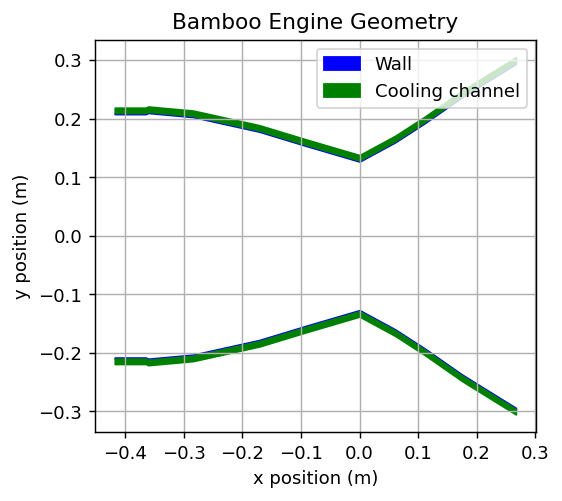

In [10]:
engine.plot_geometry()
plt.title("Bamboo Engine Geometry")
plt.show()

In [11]:
#Run simulation without fudge factor
bamboo_data = engine.steady_heating_analysis(to_json = False, 
                                             h_gas_model = 'bartz-sigma', 
                                             h_coolant_model = 'gnielinski')

NOTE: No enthalpy data provided for the coolant - will use specific heat capacity to predict temperature rises.


In [12]:
#Convert heat transfer rates to per unit area - divide by the circumference
q_per_area = np.zeros(len(bamboo_data['q_dot']))
for i in range(len(q_per_area)):
    q_per_area[i] = bamboo_data['q_dot'][i]/(2*np.pi*engine.y(bamboo_data["x"][i]))


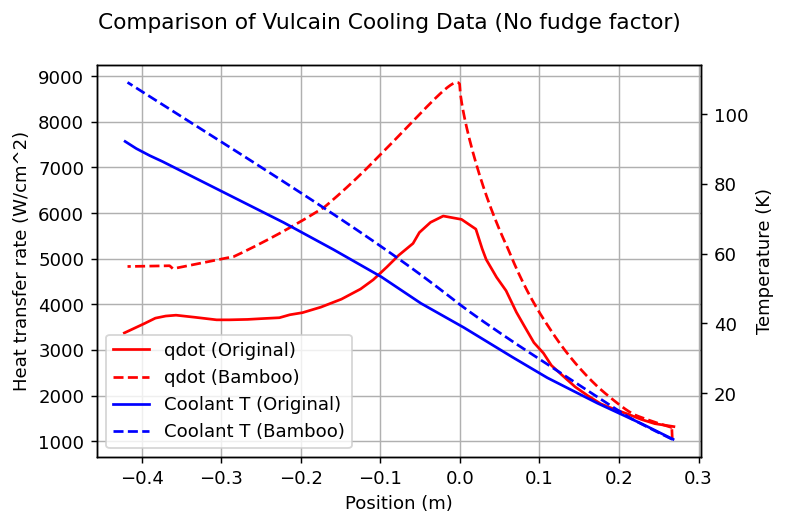

In [13]:
#Compare results with data from paper
fig, ax1 = plt.subplots()
fig.suptitle("Comparison of Vulcain Cooling Data (No fudge factor)")

#Plot heat transfer rates
ax1.plot(np.array(heat_transfer_rate["x"]) - throat_pos, heat_transfer_rate["y"], label="qdot (Original)", color="red")
ax1.plot(bamboo_data["x"], q_per_area*(1e-2)**2, label="qdot (Bamboo)", color="red", linestyle = "--")

ax1.set_xlabel("Position (m)")
ax1.set_ylabel("Heat transfer rate (W/cm^2)")
ax1.grid()

#Plot coolant temperatures on the same axis
ax2 = ax1.twinx()       
ax2.plot(np.array(coolant_temperature_data["x"]) - throat_pos, coolant_temperature_data["y"], label="Coolant T (Original)", color="blue")
ax2.plot(bamboo_data["x"], bamboo_data["T_coolant"], label="Coolant T (Bamboo)", color="blue", linestyle = "--")

ax2.set_ylabel("Temperature (K)")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc = 'lower left')

plt.show()

In [17]:
#Rerun simulation and plot results with fudge factor
bamboo_data = engine.steady_heating_analysis(to_json = False, 
                                             h_gas_model = 'bartz-sigma', 
                                             h_coolant_model = 'gnielinski', 
                                             gas_fudge_factor = 1.3)

NOTE: No enthalpy data provided for the coolant - will use specific heat capacity to predict temperature rises.


In [18]:
#Convert heat transfer rates to per unit area - divide by the circumference
q_per_area = np.zeros(len(bamboo_data['q_dot']))
for i in range(len(q_per_area)):
    q_per_area[i] = bamboo_data['q_dot'][i]/(2*np.pi*engine.y(bamboo_data["x"][i]))


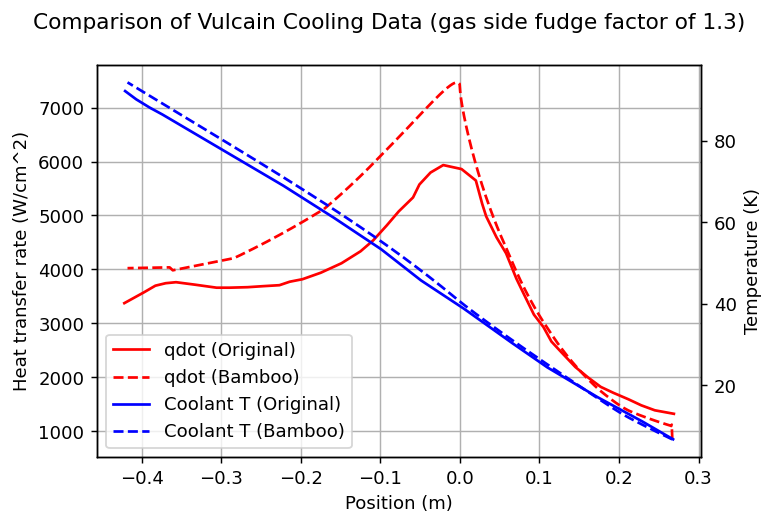

In [19]:
#Compare results with data from paper
fig, ax1 = plt.subplots()
fig.suptitle("Comparison of Vulcain Cooling Data (gas side fudge factor of 1.3)")

#Plot heat transfer rates
ax1.plot(np.array(heat_transfer_rate["x"]) - throat_pos, heat_transfer_rate["y"], label="qdot (Original)", color="red")
ax1.plot(bamboo_data["x"], q_per_area*(1e-2)**2, label="qdot (Bamboo)", color="red", linestyle = "--")

ax1.set_xlabel("Position (m)")
ax1.set_ylabel("Heat transfer rate (W/cm^2)")
ax1.grid()

#Plot coolant temperatures on the same axis
ax2 = ax1.twinx()       
ax2.plot(np.array(coolant_temperature_data["x"]) - throat_pos, coolant_temperature_data["y"], label="Coolant T (Original)", color="blue")
ax2.plot(bamboo_data["x"], bamboo_data["T_coolant"], label="Coolant T (Bamboo)", color="blue", linestyle = "--")

ax2.set_ylabel("Temperature (K)")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc = 'lower left')

plt.show()